# 0. tool. Ничего делать не надо :) Забирайте себе задаром!

<br>

Перед вами последняя домашка этого семестра - остался final-boss! <br>
Вам дана авторская рисовалка - ваше ОРУЖИЕ в борьбе с этим боссом. <br>
Вы также вольны модифицировать ее как вам вздумается. Итак, рисовалка получает от вас данные и набор 2D/3D dimensionality-reductor'ов, после чего рисует полученные эмбеддинги (см. пример на крабах).
    

**Features:**
- 3D renderer: `plotly`
    - hue-раскраска
    - возможность спрятать часть данных кликом по легенде (если hue категориальная)
- 2D renderer: `bokeh`
    - поддержка ColumnDataSource-sharing между графиками (используйте инструменты!)
    - hue-раскраска
    - возможность спрятать часть данных кликом по легенде (если hue категориальная)

**Задание:** Изучите рисовалку и ее возможности (user-friendly interface для знакомых с прошлой домашкой). В `reductors.py` можно дописывать необходимые вам для дальнейших исследований функции (например, `spectral embedding`, чтобы понимать, с чего стартуют ваши t-SNE / UMAP, а также выхватывать принципиально отличающиеся паттерны). Если у вас 1000 крабов считается сильно дольше, чем секунд 10 (с оптимальным n_jobs) на примере ниже, возможно вам стоит попробовать ускорялки (см. блок 1) или делать домашку в колабе / кегле или отказаться от t-SNE, пока сильно не понадобится (например, аргумент dof).

**Рекомендуется:**
- пересмотреть / посмотреть семинар по снижению размерности
- пересмотреть / посмотреть семинар по plotly, bokeh

**Бонусные баллы:**

За реализацию в рисовалке некоторых недостающих функций можно получить бонусные баллы (не идут в total в формуле курса, но считаются за ваши).

- (1 балл) сделать нормальную решетку графиков (чтобы они выкладывались "в матрицу", а не в линию, как сейчас)
- (3 балла) добавить возможность пользователю задать hover_data, то есть подать на вход данные, которые будут подсвечиваться при наведении на точки. (сейчас только plotly подсвечивает по умолчанию x,y,z координаты. нужно больше!)
    - (1 балл) для plotly
    - (2 балла) для bokeh
- (3 балла) прикрутить динамическую прозрачность в зависимости от колонки
    - (1 балл) для plotly
    - (2 балла) для bokeh
- (5 баллов) приделать к plotly / bokeh графикам dropdown menu, позволяющее в режиме реального времени поменять цвет + легенду на другую колонку
    - (2 балла) для plotly
    - (3 балла) для bokeh
- (? баллов) устранение каких-либо багов, обнаруженных в данной рисовалке
- (? баллов) что-либо еще более-менее существенное будет субъективно оценено в зависимости от адекватности / грандиозности


Note: вы можете как допиливать существующую рисовалку, так и сделать новую, с не меньшим функционалом

**Оформление бонусного задания:**
- обязательно укажите, какой функционал вы реализовываете
    - если вы реализовываете что-то свое, подробно опишите добавляемый функционал и для чего он по-вашему может быть полезен
    - за бесполезный функционал (цветовые схемы, смена палитр, просто "стало красивее", шрифт стал больше...) баллов не будет
    - за полезный, но маленький по объему кода функционал можно получить баллы только в совокупности с другими такими же
- обязательно приведите примеры работы каждого из функционалов
    - примеры должны демонстрировать все заявленные возможности
    - если нужно куда-то нажимать, зумиться и т.п. - пишите об этом
- если вы модифицируете существующую рисовалку, выделите комментариями блоки кода, которые вы добавили,
    и подпишите что эти блоки делают
- весь итоговый бонусный код должен быть помещен в этот ноутбук для проверки (НЕ в модули) с пометкой "Бонусный раздел"
- весь бонусный функционал должен запускаться на dummy-данных, сделанных с помощью numpy / sklearn / руками и тп.
    - мы будем запускать ваши примеры в колабе, поэтому нужно, чтобы мы могли быстро сделать данные из ячейки и запустить на них
        рисовалку, а не грузить какие-то датасеты в колаб
- вы **можете** сделать только бонусы, без основного блока

In [2]:
import pandas as pd, numpy as np

%load_ext autoreload
%autoreload 2

# Считаем крабов для примера работы рисовалки
tr = pd.read_csv('crabs_train.csv')

tr.columns = tr.columns.str.lower()
tr.rename(columns={
    'shucked weight': 'shucked_weight',
    'viscera weight': 'viscera_weight',
    'shell weight': 'shell_weight',
}, inplace=True)
tr.head(3)

,sex,length,diameter,height,weight,shucked_weight,viscera_weight,shell_weight,age
0,F,1.3625,1.0000,0.3625,20.879407,8.703297,5.811648,6.378637,15
1,F,1.4750,1.1250,0.4000,28.576296,10.149121,6.406987,9.638830,13
2,M,1.8750,1.4375,0.5125,62.652395,38.300174,11.708343,14.217274,11


In [32]:
# ПРИМЕРОЧНАЯ

from utils.utils import plot_dim_reduction
from utils.reductors import *
from collections import namedtuple


'''
Рисовалка поддерживает mapper_dict следующего вида:

mapper_dict = {
    mapper_name: {
        'params': словарь параметров reductor`a (алгоритм dim reduction, см. reductors.py),
        'func': Callable(data, params) -> embedding (см. reductors.py),
        'hue': tuple вида (hue_col_name: str, is_categorical: bool) - инфа о hue-колонке, [optional]
        'features': можно указать фичи, по которым будет считаться метрика конкретно для данного mapper`a [optional]
    },
    ...
}
'''

hue_info = namedtuple('hue_info', ['field_name', 'is_categorical']) # Для удобства восприятия. Можно подавать и обычный tuple

# ИЗМЕНЕНИЯ НА ДОП БАЛЛЫ
hover_data_columns = ['length', 'diameter', 'height', 'weight'] # И для плотли и для бокех
opacity_column = 'height' # Только для бокех

mapper_dict = {
    'tsne 2D': {
        'params': {
           'n_jobs': 1, # <------------------- увеличивайте, только если ускоряет
           'verbose': False, # <------------------- делайте True, если работает медленно, чтобы понять, что к чему
           'n_components': 2
        },
        'hue': None, # не красить
        'func': make_tsne,
    },
    'UMAP 2D': {
        'params': {
           'n_neighbors': 11,
           'min_dist': 0.1,
           'n_jobs': 1,
           'verbose': False,
           'n_components': 2
        },
        'hue': hue_info(field_name='sex', is_categorical=True), # можно указать, чтобы не красить в default_hue_info
        'func': make_umap,
    },
    'PCA 2D': {
        'params': {
           'n_components': 3
        },
        'func': make_pca,
        
        # 
        'features': ['weight', 'shucked_weight', 'shell_weight']  
    },
}

plot_dim_reduction(
    data = tr.sample(1_000),
    mapper_dict=mapper_dict,
    default_features=tr.drop(columns=['sex', 'age']).columns,
    default_hue_info=hue_info(field_name='sex', is_categorical=False), # namedtuple, hue-info по умолчанию
    row_height=450,
    hover_data=hover_data_columns,
    opacity_col = opacity_column
)

Loading BokehJS ...

100%|██████████| 3/3 [00:30<00:00, 10.04s/it]


    'data': [{'customdata': array([[ 0.8625    ,  0.6625    ,  0.225     ,  5.75…

# 1. Boss. Курильщики... (15 баллов)

В качестве финального этапа первого семестра вам предстоит объединить все полученные вами знания, чтобы ответить на простой, казалось бы вопрос: "smoking or not smoking?". Используйте все пройденные вами методы (и только их!) для исследования этой задачи и ответа на главный вопрос... и сдать решение на kaggle :)

[зарегистрироваться в соревновании](https://www.kaggle.com/t/3effa2dc05114bb0b66dbbf365084e2e)


[лидерборд](https://www.kaggle.com/competitions/aim-2023-smoking/leaderboard)

В тренировочной выборке всего 10к размеченных объектов, в тесте - 150k. Изворачивайтесь, придумывайте, как решить задачу имеющимися знаниями и инструментами. Рисуйте, изучайте, записывайте найденные инсайты на бумагу и обращайте их в свою пользу!

**Задание с хорошей вероятностью включает в себя:**
- анализ распределений признаков и их физического смысла
- предобработка и трансформация данных
- использование методов понижения размерности для визуализации
    - совет: чтобы иметь возможность интерактивно взаимодействовать с 2D / 3D графиками, не рисуйте много точек
        - для i5 12600K 5к точек - хорошо, 10k точек - уже неприятно, 25к - невозможно :)
    - совет: записывайте на бумаге все увиденное и как это увиденное было получено
    - совет: вы часто будете встречать какие-то кластеры - попытайтесь понять, по каким критериям данные на них бьются, кто есть 
        представители каждого из них. Возможно, к каким-то кластерам нужен свой подход

- использование методов понижения размерности для сворачивания в более плотное, информативное пространство
- использование методов кластеризации
    - для генерации новых признаков
    - для доразметки выборки
    - для генерации новых hue-колонок
    - для бог знает чего еще!
    - советую HDBSCAN:
        - [`hdbscan`](https://github.com/scikit-learn-contrib/hdbscan) для ознакомления с принципом работы / документацией (от авторов UMAP!)
        - [`fast_hdbscan`](https://github.com/TutteInstitute/fast_hdbscan) - ускорение hdbscan для маломерных евклидовых пространств от тех же авторов (как раз для применения в 2D/3D после понижения размерности!)
        - [доклад 1](https://youtu.be/ayZQj4llUSU?si=hBQ3z7gFYcJvNS07) (от авторов)
        - [доклад 2](https://youtu.be/dGsxd67IFiU?si=dxDxWENIssBdAeM9) (от авторов)
        - [оригинальная статья](https://sci-hub.ru/10.1007/978-3-642-37456-2_14)
            (читать параллельно с [этим](https://hdbscan.readthedocs.io/en/latest/how_hdbscan_works.html) для полного понимания)
        - если разберетесь, как интерпретировать построенное дерево иерархий кластеров и работать с ним - будете PRO!
    - ... и k-means, если вы видите по картинке, сколько вам нужно кластеров (и если они более-менее сферические)

- использование методов поиска ближайших соседей почти для всего
- решение вопроса с валидацией при маленьком размере выборки
- подбор гиперпараметров (используйте с умом, не увлекайтесь)
- освоение "ускорялок" существующих методов
    - CPU: [sklearnex](https://github.com/intel/scikit-learn-intelex)
        (ускорить sklearn одной строчкой, см. [семинар](https://youtu.be/YAyY59CETsQ?si=v7VpEd-CYK8WoB8D&t=2493))
    - GPU: [cuML](https://github.com/rapidsai/cuml) (ускорить tSNE, UMAP, кластеризацию, ...)
    - GPU pandas: [cuDF](https://github.com/rapidsai/cudf) (ускорить pandas в одну строчку)
    - в этих библиотеках ускорено почти все, чем вы будете пользоваться, возможно, с ограничениями по функционалу
    - используйте, если есть проблемы со скоростью, разобраться НЕ в 5 часов утра довольно просто
    - чтобы начать использовать, достаточно написать простенькие функции в `reductors.py` по аналогии с имеющимися там

не стоит забывать и про линейные модели... возможно, они тоже смогут вам помочь на каком-то этапе вашего пути


<br>

**Максимальный балл за задание можно получить за выполнение следующих пунктов:**
- `research` (8 баллов)
    - наличие research-[нотубука/html], прикрепленного в классруме
        - правила оформления и подробности оценивания читайте в прикрепленном research-ноутбуке
    - присутствие в нем всевозможных интересных находок / инсайтов о данных с вашими рассуждениями / выводами на эту тему
    - чем большее количество полезной информации будем вами извлечено из представленных находок, тем больше баллов
- `kaggle` (7 баллов)
    - побитие бейслайн[a/ов] на kaggle (подробнее - следите за kaggle)
    - наличие в этом ноутбуке адекватного пайплайна (я не имею в виду обязательность использования sklearn.pipeline!) от начала 
        работы с данными до получения предсказаний
    - наличие адекватных и в меру развернутых рассуждений на тему того, что вы делаете на каждом этапе и почему
        - наличие слов обязательно для получения максимального балла за это задание

### Импортируем библиотеки

In [154]:
from utils.utils import plot_dim_reduction
from utils.reductors import *
from collections import namedtuple
import pandas as pd
import numpy as np
from collections import namedtuple
import matplotlib.pyplot as plt
import seaborn as sns
import shap
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import balanced_accuracy_score
import optuna
import warnings
from lightgbm import LGBMClassifier

warnings.simplefilter('ignore')

In [166]:
tr = pd.read_csv('train.csv')
tst = pd.read_csv('test.csv').assign(smoking=-1)

tr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 23 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   age                  10000 non-null  int64  
 1   height_cm            10000 non-null  int64  
 2   weight_kg            10000 non-null  int64  
 3   waist_cm             10000 non-null  float64
 4   eyesight_left        10000 non-null  float64
 5   eyesight_right       10000 non-null  float64
 6   hearing_left         10000 non-null  int64  
 7   hearing_right        10000 non-null  int64  
 8   systolic             10000 non-null  int64  
 9   relaxation           10000 non-null  int64  
 10  fasting_blood_sugar  10000 non-null  int64  
 11  cholesterol          10000 non-null  int64  
 12  triglyceride         10000 non-null  int64  
 13  hdl                  10000 non-null  int64  
 14  ldl                  10000 non-null  int64  
 15  hemoglobin           10000 non-null  

In [156]:
tr['smoking'].value_counts()

smoking
0    5636
1    4364
Name: count, dtype: int64

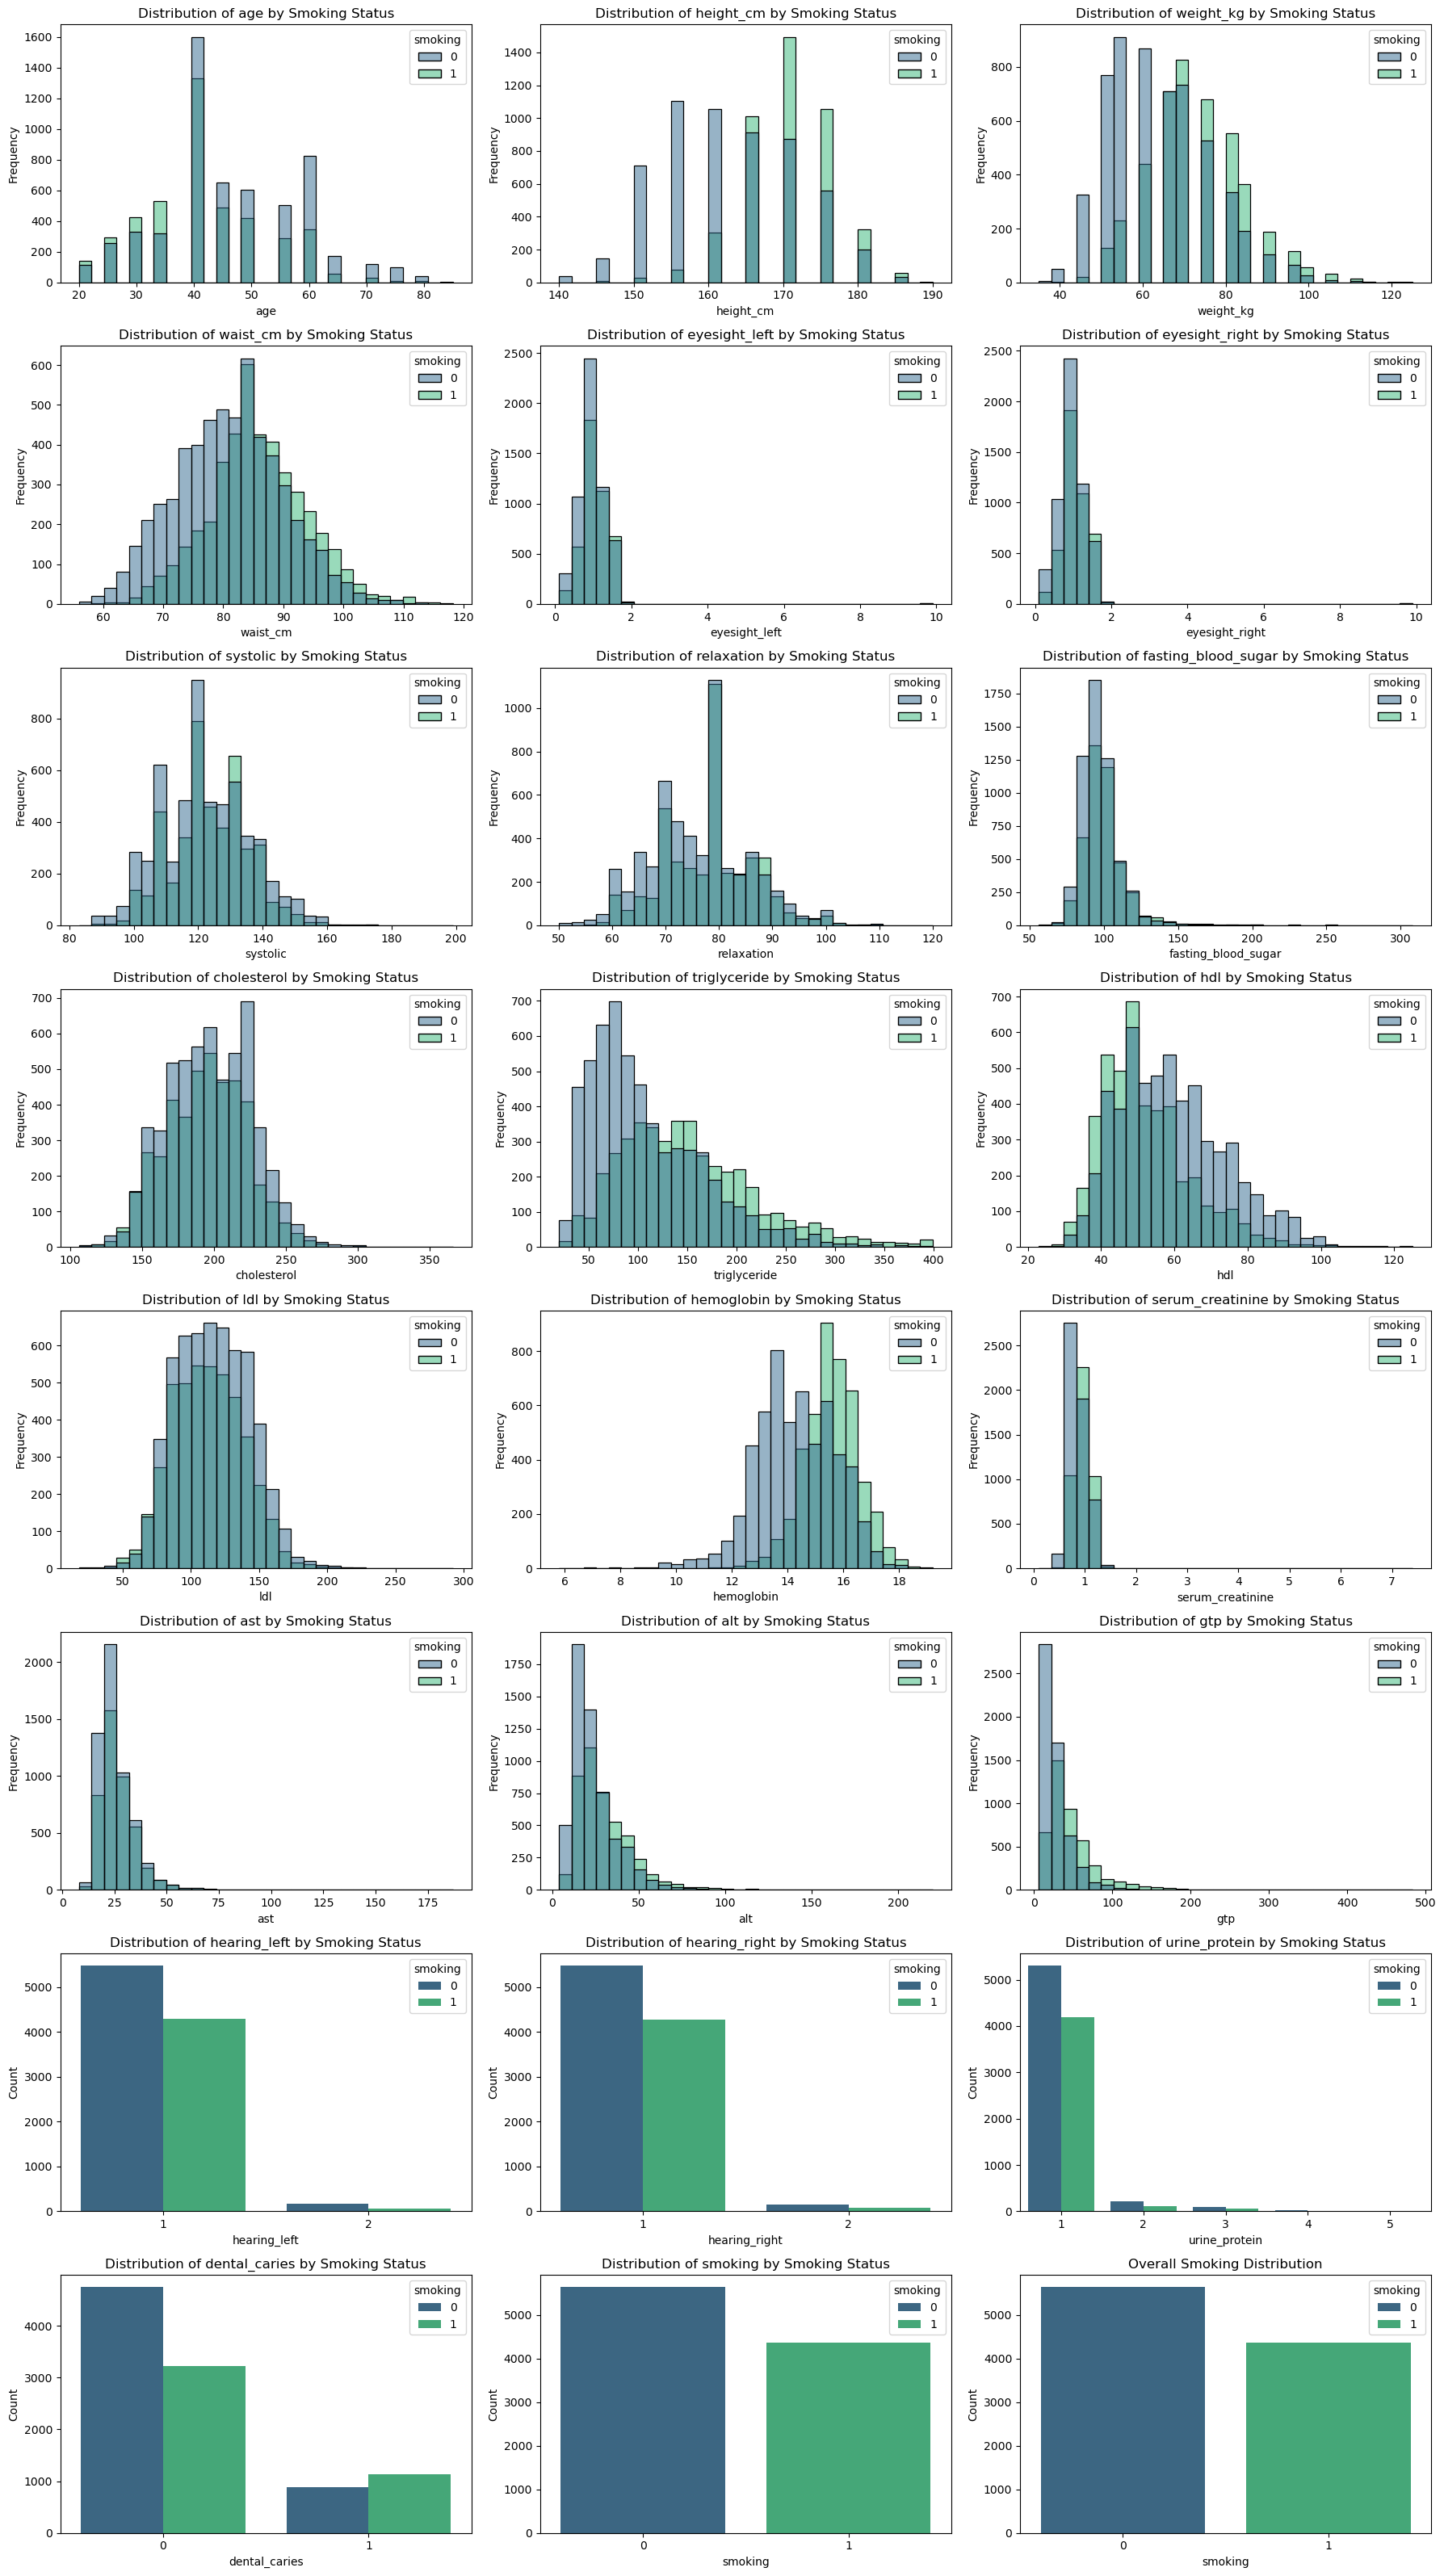

In [157]:
def plot_distributions_with_smoking(data, treshold=5):
    """
    Рисовалка для просмотра распределений
    """

    int_vars = []
    cat_vars = []

    for col in data.columns:
        if data[col].nunique() > treshold:
            int_vars.append(col)
        else:
            cat_vars.append(col)

    total_plots = len(int_vars) + len(cat_vars)

    n_rows = total_plots // 3 + (total_plots % 3 > 0)
    fig, axes = plt.subplots(n_rows, 3, figsize=(18, n_rows*4))
    axes = axes.flatten()

    for i, var in enumerate(int_vars):
        sns.histplot(data, x=var, hue='smoking', bins=30, ax=axes[i], palette='viridis')
        axes[i].set_title(f'Distribution of {var} by Smoking Status')
        axes[i].set_ylabel('Frequency')
        
    for j, var in enumerate(cat_vars):
        sns.countplot(x=var, hue='smoking', data=data, ax=axes[i+j+1], palette='viridis')
        axes[i+j+1].set_title(f'Distribution of {var} by Smoking Status')
        axes[i+j+1].set_ylabel('Count')
    
    sns.countplot(x='smoking',hue='smoking', data=data, ax=axes[-1], palette='viridis')
    axes[-1].set_title('Overall Smoking Distribution')
    axes[-1].set_ylabel('Count')

    plt.tight_layout()
    plt.show()

plot_distributions_with_smoking(tr)


### Feature importance

Проверим признаки на наличие корреляции(см. research - Не подтвердилось) и важности (с помощью добавление случайной колонки).

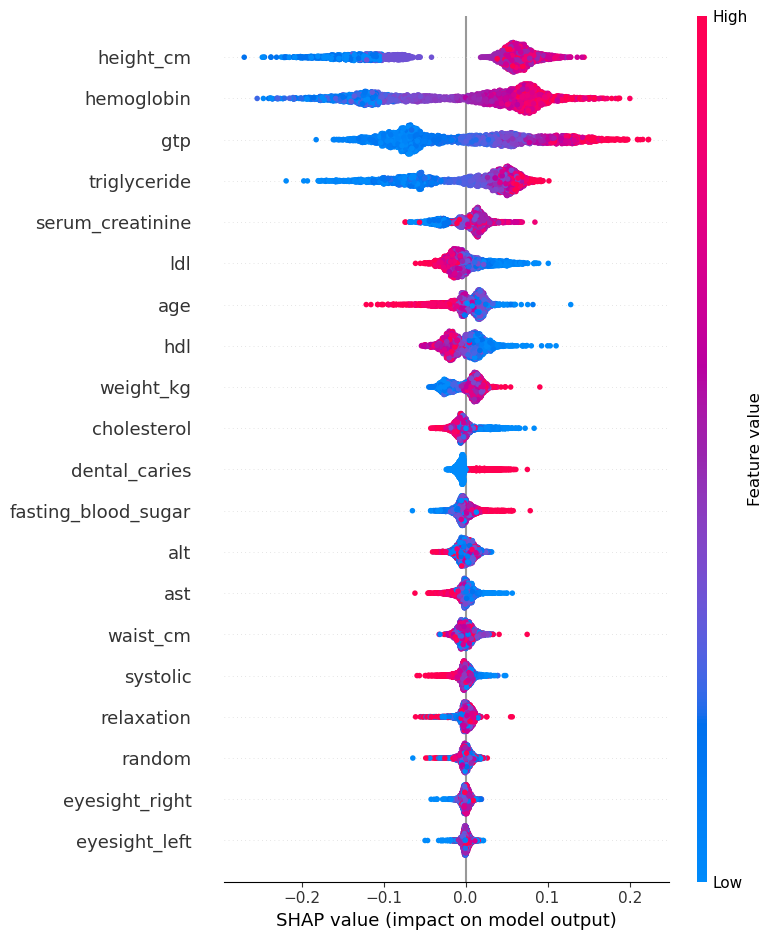

In [158]:
# Добавим колонку со случайными значениями, признаки с "важностью" ниже или близко к ней не будут иметь смысла.
tr['random'] = np.random.randint(1, len(tr) + 1, size=len(tr))

target = 'smoking'
X = tr.drop(target, axis=1)
y = tr[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=239)

model = RandomForestClassifier(n_estimators=100, random_state=239)
model.fit(X_train, y_train)

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values[1], X_test, plot_type="dot")

Исходя из shap-графика выше, можно сделать вывод об отсутсвии значимости eyesight, так как она ниже "случайной" фичи. Также у признаков ниже "alt",
похожие на случайную значения и близкие к нулю, от этих признаков мы избавимся.

In [169]:
tr.drop(['eyesight_right', 'eyesight_left', 'random', 'relaxation', 'systolic', 'waist_cm'], axis=1, inplace=True)

In [170]:
tst.drop(['eyesight_right', 'eyesight_left', 'relaxation', 'systolic', 'waist_cm'], axis=1, inplace=True)

Добавим фичи на основе ресерча

In [171]:
def create_features(df):
    df['BMI'] = df['weight_kg'] / ((df['height_cm'] / 100) ** 2)
    df['HA_Ratio'] = df['height_cm'] / df['age']
    
    df['HDL-LDL Ratio'] = df['hdl'] / df['ldl']
    df["HDL-triglyceride Ratio"] = df["hdl"] / df["triglyceride"]
    df["LDL-triglyceride Ratio"] = df["ldl"] / df["triglyceride"]
    df["Liver Enzyme Ratio"] = df["ast"] / df["alt"]
    return df

for x in [tr, tst]:
    create_features(x)

Сделаем первый submission, прогнав все через lightGBM на рандомных параметрах, в зависимости от результатов, будет принято решение, использовать ли кластеризацию (для новых признаков или в целом для решений как в пайплайне)

In [172]:
def light_pipline(train_df, test_df, submission_number=1):
    X_train = train_df.drop('smoking', axis=1)
    y_train = train_df['smoking']
    X_test = test_df.drop('smoking', axis=1)

    train_data = lgb.Dataset(X_train, label=y_train)

    params = {
        'objective': 'binary',
        'boosting_type': 'gbdt',
        'metric': 'binary_logloss',
        'num_leaves': 31,
        'learning_rate': 0.05,
        'feature_fraction': 0.9,
        'bagging_fraction': 0.8,
        'bagging_freq': 5,
        'verbose': 0
    }

    gbm = lgb.train(params,
                    train_data,
                    num_boost_round=100,
                    )

    y_test_pred_prob = gbm.predict(X_test, num_iteration=gbm.best_iteration)
    y_test_pred_class = (y_test_pred_prob >= 0.5).astype(int)

    submission = pd.DataFrame({'id': tst.index, 'smoking': y_test_pred_class})
    submission.to_csv(f'Babaev_submission_{submission_number}.csv', index=False)

In [173]:
light_pipline(tr,tst)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines


Получили скор 0.547 - неплохо, но попробуем улучшить модель. Попробуем добавить признаки с помощью методов кластеризации.
После некоторых итераций я склонился к варианту, предложенному в дамми, ибо при большей загрузке признаков был какой-то трэш.

In [174]:
tr['new_log_gtp'] = np.log1p(tr.gtp)
tst['new_log_gtp'] = np.log1p(tst.gtp)
train_x, valid_x, train_y, valid_y = train_test_split(tr, tr['smoking'], test_size=0.2, random_state=42)

In [175]:
my_favorite_cols = ['age', 'height_cm', 'weight_kg', 'hemoglobin', 'new_log_gtp']
plot_cols = np.r_[my_favorite_cols, ['smoking']]
plot_data = train_x[plot_cols].copy()

In [176]:
hue_info = namedtuple('hue_info', ['field_name', 'is_categorical'])

In [177]:
def plot_standard_embeddings(plot_data, features, return_results=False, sample_points=10000):
    '''
    рисует "какие-то" эмбеддинги с hue='smoking' на одних и тех же фичах features
    '''
    mapper_dict = {
        'tsne 2D perplexity=60 exaggeration=4': {
            'params': {
                'n_jobs': 2,
                'perplexity': 60,
                'verbose': False,
                'n_components': 2,
                'exaggeration': 4,
                'neighbors': 'pynndescent' # annoy - neighbors по умолчанию - почему-то виснет на .transform
            },
            'func': make_tsne,
        },
        'tsne 2D perplexity=60 exaggeration=4 dof=0.5': {
            'params': {
                'n_jobs': 2,
                'perplexity': 60,
                'verbose': False,
                'n_components': 2,
                'exaggeration': 4,
                'dof': 0.5,
                'neighbors': 'pynndescent'
            },
            'func': make_tsne,
        },
        'UMAP 2D n_neighbors=17': {
            'params': {
               'n_neighbors': 17,
               'min_dist': 0.1,
               'n_jobs': 2,
               'verbose': False,
               'n_components': 2
            },
            'func': make_umap,
        },
        'PCA 3D': {
            'params': {
               'n_components': 3
            },
            'func': make_pca,
        },
    }

    res = plot_dim_reduction(
        data=plot_data,
        mapper_dict=mapper_dict,
        default_features=features,
        default_hue_info=hue_info(field_name='smoking', is_categorical=True),
        row_height=450,
        return_results=return_results
    )
    return res

# И нарисуем наши первые эмбеддинги!
means = plot_data[my_favorite_cols].mean(axis=0)
stds = plot_data[my_favorite_cols].std(axis=0)

plot_data.loc[:, my_favorite_cols] = (plot_data.loc[:, my_favorite_cols] - means) / stds
results = plot_standard_embeddings(plot_data, my_favorite_cols, return_results=True, sample_points=plot_data.shape[0])

Loading BokehJS ...

  0%|          | 0/4 [00:00<?, ?it/s]

100%|██████████| 4/4 [17:07<00:00, 256.76s/it]


    'data': [{'hovertemplate': 'smoking=1<br>x=%{x}<br>y=%{y}<br>z=%{z}<extra></…

In [178]:
results

{'tsne 2D perplexity=60 exaggeration=4': {'embedding': TSNEEmbedding([[ 1.09817533,  1.62533944],
                 [-0.90729471,  1.07598703],
                 [ 2.91780703,  1.04501862],
                 ...,
                 [ 1.1540103 , -2.34139107],
                 [ 0.75624729,  1.87651738],
                 [ 4.02767957, -0.20184029]]),
  'mapper': None},
 'tsne 2D perplexity=60 exaggeration=4 dof=0.5': {'embedding': TSNEEmbedding([[ 2.04501512,  1.12796951],
                 [ 0.3849079 ,  0.5796329 ],
                 [ 4.20515286,  1.20575145],
                 ...,
                 [ 3.99566205, -1.83116715],
                 [ 1.65493601,  1.2333821 ],
                 [ 5.38992973,  0.73183188]]),
  'mapper': None},
 'UMAP 2D n_neighbors=17': {'embedding': array([[ 3.5498438 , -0.05490443],
         [ 5.314359  ,  2.32997   ],
         [-1.8468628 ,  2.1802819 ],
         ...,
         [ 2.1818848 ,  6.0313597 ],
         [ 3.619116  , -0.14229886],
         [-3.7394981 ,

По результатам tsne можно выделить два кластера.

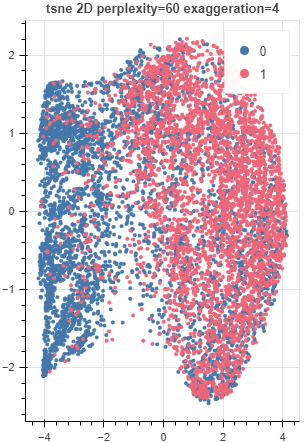

In [179]:
tsne_embedding_res = results['tsne 2D perplexity=60 exaggeration=4']['embedding']
embedding_tranformed_train = tsne_embedding_res.copy()
embedding_tranformed_val = tsne_embedding_res.transform(valid_x[my_favorite_cols])
embedding_tranformed_test = tsne_embedding_res.transform(tst[my_favorite_cols])

Добавим эти эмбединги в наши датафреймы как признаки.

In [180]:
train_x['tsne_dim1'] = embedding_tranformed_train[:, 0]
train_x['tsne_dim2'] = embedding_tranformed_train[:, 1]

valid_x['tsne_dim1'] = embedding_tranformed_val[:, 0]
valid_x['tsne_dim2'] = embedding_tranformed_val[:, 1]

tst['tsne_dim1'] = embedding_tranformed_test[:, 0]
tst['tsne_dim2'] = embedding_tranformed_test[:, 0]


In [181]:
combined_tsne_features = pd.concat([train_x[['tsne_dim1', 'tsne_dim2']], valid_x[['tsne_dim1', 'tsne_dim2']]])
tr = tr.merge(combined_tsne_features, left_index=True, right_index=True, how='left')

Потюним параметры lightGBM

In [ ]:
params = {
        'objective': 'binary',
        'boosting_type': 'gbdt',
        'metric': 'binary_logloss',
        'num_leaves': 31,
        'learning_rate': 0.05,
        'feature_fraction': 0.9,
        'bagging_fraction': 0.8,
        'bagging_freq': 5,
        'verbose': 0
    }

In [192]:
def objective(trial):
      
    param = {
        'objective': 'binary',
        'metric': 'binary_logloss',
        'verbosity': -1,
        'boosting_type': 'gbdt',
        'num_leaves': trial.suggest_int('num_leaves', 2, 256),
        'learning_rate': 0.05, #trial.suggest_loguniform('learning_rate', 1e-8, 1.0),
        'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0),
        'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.4, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
    }

    model = LGBMClassifier(**param)
    model.fit(train_x, train_y)
    pred_labels = model.predict(valid_x)

    acc = balanced_accuracy_score(valid_y, pred_labels)

    return acc

In [193]:
def light_pipline_tuned(train_x, train_y, valid_x, valid_y, target, train_df, test_df, submission_number=1):
    
    X_train = train_df.drop(target, axis=1) if target in train_df.columns else train_df
    X_test = test_df.drop(target, axis=1) if target in test_df.columns else test_df

    study = optuna.create_study(direction='maximize')
    study.optimize(lambda trial: objective(trial), n_trials=100)
    
    params = study.best_params
    
    final_model = LGBMClassifier(**params)
    final_model.fit(X_train, train_df[target])

    y_test_pred_class = final_model.predict(X_test)

    submission = pd.DataFrame({'id': tst.index, 'smoking': y_test_pred_class})
    submission.to_csv(f'Babaev_submission_{submission_number}.csv', index=False)

    return params

In [194]:
params = light_pipline_tuned(train_x, train_y, 
                             valid_x, valid_y, 
                             'smoking', tr, tst, submission_number=16)

[I 2023-12-19 03:16:42,753] A new study created in memory with name: no-name-deaaace4-5fd0-4cd8-905a-47c7947f42dc


[I 2023-12-19 03:16:43,076] Trial 0 finished with value: 0.7263070991637679 and parameters: {'num_leaves': 108, 'feature_fraction': 0.823018505785982, 'bagging_fraction': 0.6153385779490741, 'bagging_freq': 6}. Best is trial 0 with value: 0.7263070991637679.
[I 2023-12-19 03:16:43,357] Trial 1 finished with value: 0.7697923964747964 and parameters: {'num_leaves': 247, 'feature_fraction': 0.40900525872179283, 'bagging_fraction': 0.5230671104327338, 'bagging_freq': 2}. Best is trial 1 with value: 0.7697923964747964.
[I 2023-12-19 03:16:43,779] Trial 2 finished with value: 0.7373786725993665 and parameters: {'num_leaves': 181, 'feature_fraction': 0.9154801858825103, 'bagging_fraction': 0.9394993252875186, 'bagging_freq': 5}. Best is trial 1 with value: 0.7697923964747964.
[I 2023-12-19 03:16:43,910] Trial 3 finished with value: 0.7578163731045475 and parameters: {'num_leaves': 38, 'feature_fraction': 0.6487054277973741, 'bagging_fraction': 0.5747812706056594, 'bagging_freq': 4}. Best is t

[LightGBM] [Warning] feature_fraction is set=0.4924727546106073, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4924727546106073
[LightGBM] [Warning] bagging_fraction is set=0.632309864461674, subsample=1.0 will be ignored. Current value: bagging_fraction=0.632309864461674
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] feature_fraction is set=0.4924727546106073, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4924727546106073
[LightGBM] [Warning] bagging_fraction is set=0.632309864461674, subsample=1.0 will be ignored. Current value: bagging_fraction=0.632309864461674
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Info] Number of positive: 4364, number of negative: 5636
[LightGBM] [Info] Auto-choosing col-w

У меня наблюдается оверфит, пробить бонусный скор не удалось :(